In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


In [3]:
df = pd.read_csv('../DATA/RSCCASN.csv', parse_dates=True, index_col='DATE')

In [4]:
df.head()

,RSCCASN
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


In [5]:
df.shape

(334, 1)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 334 entries, 1992-01-01 to 2019-10-01
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   RSCCASN  334 non-null    int64
dtypes: int64(1)
memory usage: 5.2 KB


In [7]:
df.columns

Index(['RSCCASN'], dtype='object')

In [8]:
df.columns = ['Sales']

<Axes: xlabel='DATE'>

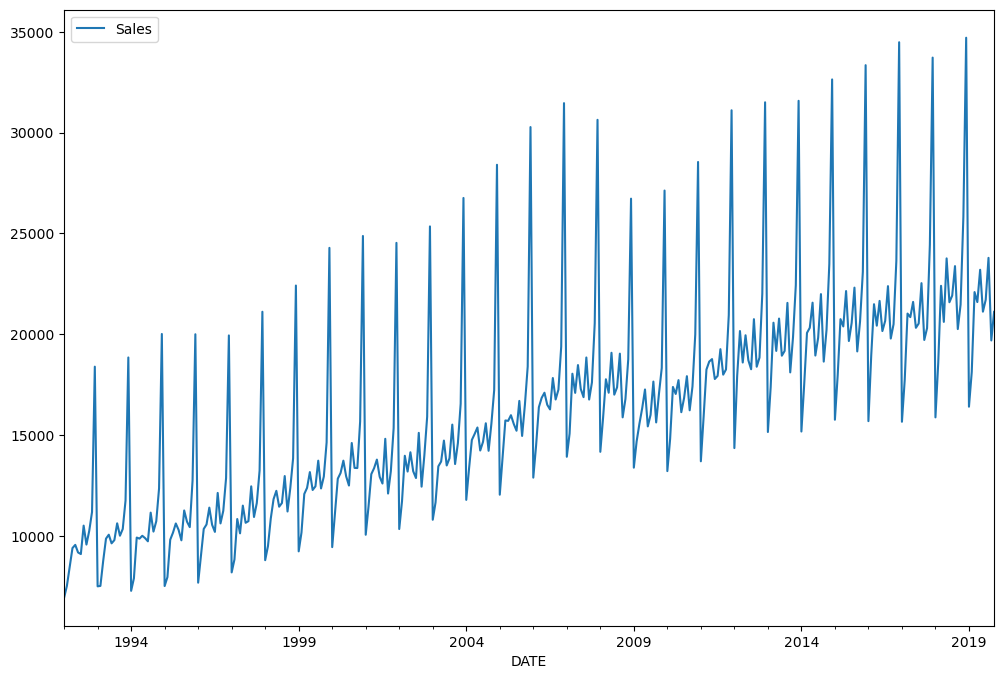

In [9]:
df.plot(figsize=(12,8))


In [10]:
test_size = 18
test_ind = len(df) - test_size

In [12]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [13]:
from sklearn.preprocessing import MinMaxScaler

In [14]:
scaler = MinMaxScaler()

In [17]:
scaler.fit(train)

MinMaxScaler()

In [18]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [19]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [21]:
lenght=12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=lenght, batch_size=1)

In [22]:
X,y = generator[0]

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [25]:
model = Sequential()

n_features = 1

model.add(LSTM(100, activation='relu', input_shape=(lenght, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40901 (159.77 KB)
Trainable params: 40901 (159.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [27]:
from tensorflow.keras.callbacks import EarlyStopping

In [28]:
early_stop = EarlyStopping(monitor='val_loss', patience=2)

In [29]:
validation_gen = TimeseriesGenerator(scaled_test, scaled_test, length=lenght, batch_size=1)

In [30]:
model.fit(generator, epochs=20, validation_data=validation_gen, callbacks=[early_stop])

Epoch 1/20
304/304 [==============================] - 1s 2ms/step - loss: 0.0281 - val_loss: 0.0081
Epoch 2/20
304/304 [==============================] - 1s 2ms/step - loss: 0.0173 - val_loss: 0.0055
Epoch 3/20
304/304 [==============================] - 1s 2ms/step - loss: 0.0084 - val_loss: 0.0028
Epoch 4/20
304/304 [==============================] - 1s 2ms/step - loss: 0.0051 - val_loss: 0.0035
Epoch 5/20
304/304 [==============================] - 1s 2ms/step - loss: 0.0029 - val_loss: 0.0014
Epoch 6/20
304/304 [==============================] - 1s 2ms/step - loss: 0.0025 - val_loss: 0.0056
Epoch 7/20
304/304 [==============================] - 1s 2ms/step - loss: 0.0025 - val_loss: 5.4263e-04
Epoch 8/20
304/304 [==============================] - 1s 2ms/step - loss: 0.0020 - val_loss: 8.4797e-04
Epoch 9/20
304/304 [==============================] - 1s 2ms/step - loss: 0.0014 - val_loss: 2.6551e-04
Epoch 10/20
304/304 [==============================] - 1s 2ms/step - loss: 0.0012 - val_

In [31]:
losses = pd.DataFrame(model.history.history)

<Axes: >

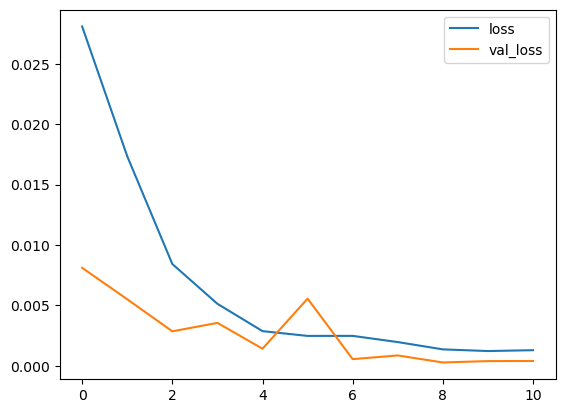

In [32]:
losses.plot()

1/1 [==============================] - 0s 9ms/step


/var/folders/7v/9x6ygmhs4n7dwfpt5qfj0_6m0000gn/T/ipykernel_997/3502031980.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


<Axes: xlabel='DATE'>

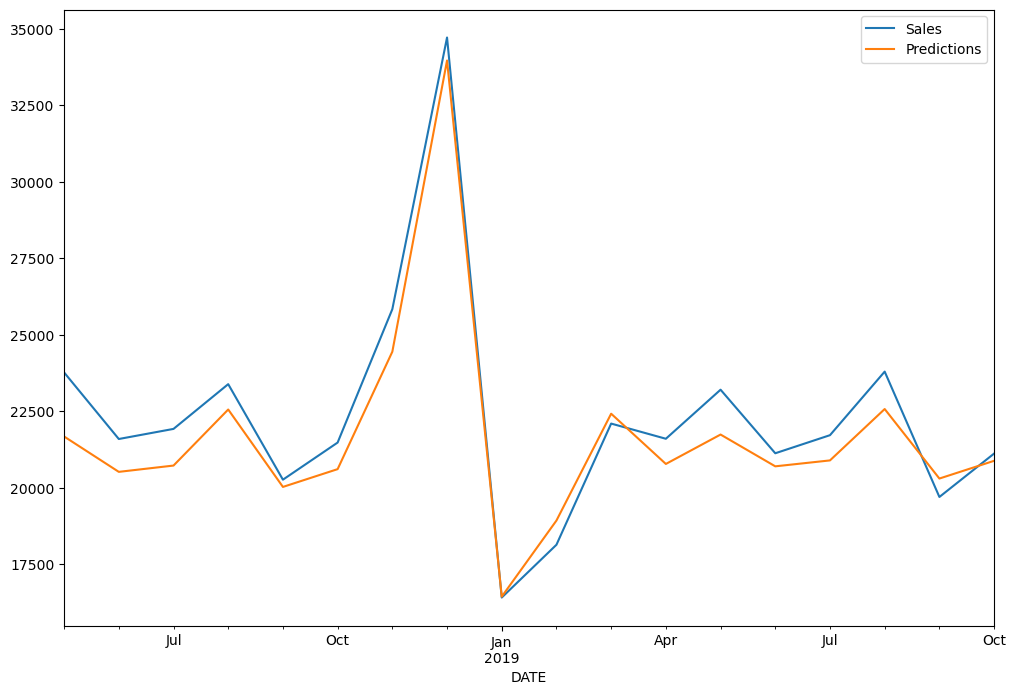

In [33]:
test_predictions = []

first_eval_batch = scaled_train[-lenght:]
current_batch = first_eval_batch.reshape((1, lenght, n_features))

for i in range(len(test)):
    current_pred = model.predict(current_batch)[0]
    test_predictions.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]], axis=1)

true_predictions = scaler.inverse_transform(test_predictions)
test['Predictions'] = true_predictions
test.plot(figsize=(12,8))